In [1]:
import os
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms
from model import EncoderCNN, DecoderRNN

## Vocab

In [2]:
with open('vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)
    word2idx = vocab.word2idx
    idx2word = vocab.idx2word

In [3]:
embed_size = 1024
hidden_size = 512

vocab_size = len(word2idx)

## Jit Creation

In [4]:
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers=3, drop=0.5)

In [5]:
encoder_file = 'encoder-700.pkl'
decoder_file = 'decoder-700.pkl'

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

<All keys matched successfully>

In [6]:
encoder.eval()
decoder.eval()

DecoderRNN(
  (embed): Embedding(9955, 1024)
  (lstm): LSTM(1024, 512, num_layers=3, batch_first=True, dropout=0.5)
  (drop): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=9955, bias=True)
)

### Encoder JIT

In [7]:
EncoderT = torch.jit.trace(encoder, torch.rand(1, 3, 224, 224))

In [8]:
EncoderT.save('encoder.pt')

### Decoder JIT

In [9]:
DecoderT = torch.jit.trace(decoder, (torch.rand(1, 1, 1024), decoder.init_hidden(1)))

In [10]:
DecoderT.save('decoder.pt')

## Infarence

In [11]:
transform_test = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

COCO location: /home/jupyter/Caption-AI/ImageCaptioning/COCODataset
Loading test Images form: /home/jupyter/Caption-AI/ImageCaptioning/COCODataset/images/test2014
Loading test Annotarions form: /home/jupyter/Caption-AI/ImageCaptioning/COCODataset/annotations/image_info_test2014.json
Vocabulary successfully loaded from vocab.pkl file!


## JIT Load

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
encoder_jit = torch.jit.load('encoder.pt', map_location=device)
decoder_jit = torch.jit.load('decoder.pt', map_location=device)

In [14]:
def init_hidden(batch_size):
    return (torch.zeros(3, batch_size, hidden_size, device = device),
            torch.zeros(3, batch_size, hidden_size, device = device))

In [15]:
def clean_sentence(output):
    parts = [data_loader.dataset.vocab.idx2word[i] for i in output][1:-1]
    sentence = " ".join(parts)
    return sentence

In [16]:
def sample(features, max_len=20):

    word_list = list()
    word_len = 0
    hidden = init_hidden(features.shape[0])

    with torch.no_grad():
        while word_len < max_len:
            out, features, hidden = decoder_jit(features, hidden)
            word_list.append(out.item())
            word_len += 1
            if out.item() == 1:
                break

    return word_list

In [17]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder_jit(image).unsqueeze(1)
    output = sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

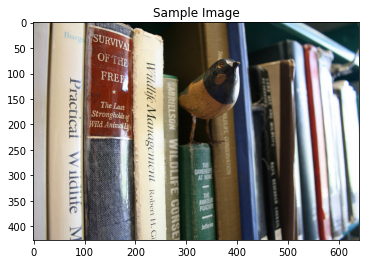

a pair of scissors and a needle on a table .


In [30]:
get_prediction()